In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import copy

In [ ]:
from google.colab import drive
#drive.mount('/gdrive')

drive.mount('/gdrive')  
%cd /
%cd '../gdrive/MyDrive/IVF/Code and Data preprocessing/Combined data'
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/
/gdrive/.shortcut-targets-by-id/1G_yc--PzQ_GbwpcMGs8mkE22gMfn1Kh5/Code and Data preprocessing/Combined data
D3_NT/   D3_T_Y/  D5_T_N/  DAY_3_Shortcut/    model.png
D3_T_N/  D5_NT/   D5_T_Y/  model_checkpoint/  Untitled0.ipynb


In [ ]:
batch_size = 4
IMG_SIZE = 299
NUM_CLASSES = 2
train_dir      = 'DAY_3_Shortcut'
validation_dir = 'DAY_3_Shortcut'

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   #rotation_range = 360,
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.2,
                                   )

validation_datagen = ImageDataGenerator( rescale = 1.0/255., validation_split=0.2 )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 4,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    subset='training') 

validation_generator =  validation_datagen.flow_from_directory( train_dir,
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (IMG_SIZE, IMG_SIZE),
                                                          subset='validation')

Found 471 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


Example of the augmented dataset


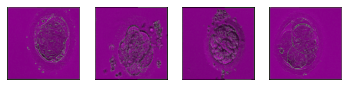

Example of the non-augmented dataset


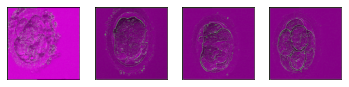

In [ ]:
x,y = train_generator.next()
print('Example of the augmented dataset')
for i in range(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()
print('Example of the non-augmented dataset')  
x,y = validation_generator.next()
for i in range(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()



In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = Xception(include_top=False, input_tensor=x, weights="imagenet")
    #model.trainable = False

    x = layers.GlobalAveragePooling2D()(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="Xception")
    
    return model

model = build_model(num_classes=NUM_CLASSES)
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

loss = 'categorical_crossentropy' #tf.keras.losses.CategoricalHinge()

metrics = ['accuracy',
           tf.keras.metrics.Recall(),
           tf.keras.metrics.Precision()
           ]

class_weight = {0: 1,
                1: 1.41975308642
              }
              #1.41975308642


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/datInterference',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=3, min_lr=0.0001),
    model_checkpoint_callback,
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 100
hist = model.fit(train_generator,
                 validation_data = validation_generator,
                 epochs=epochs,
                 callbacks=my_callbacks,
                 class_weight = class_weight,
                 #workers=2,
                 verbose=1)

Epoch 1/100
118/118 [==============================] - 37s 172ms/step - loss: 1.0759 - accuracy: 0.5032 - recall_9: 0.5032 - precision_9: 0.5032 - val_loss: 3.3473 - val_accuracy: 0.4701 - val_recall_9: 0.4701 - val_precision_9: 0.4701 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 18s 151ms/step - loss: 0.8241 - accuracy: 0.5435 - recall_9: 0.5435 - precision_9: 0.5435 - val_loss: 7.0744 - val_accuracy: 0.4188 - val_recall_9: 0.4188 - val_precision_9: 0.4188 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 18s 149ms/step - loss: 0.8419 - accuracy: 0.4735 - recall_9: 0.4735 - precision_9: 0.4735 - val_loss: 0.9029 - val_accuracy: 0.4017 - val_recall_9: 0.4017 - val_precision_9: 0.4017 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 20s 166ms/step - loss: 0.8348 - accuracy: 0.4989 - recall_9: 0.4989 - precision_9: 0.4989 - val_loss: 16.0430 - val_accuracy: 0.5897 - val_recall_9: 0.5897 - val_precision_9: 0.5897 - lr: 0.0010
Epo